In [10]:
import sys
sys.path.append("..")
from alphalens import alphalens
import pandas as pd
import pymssql
import numpy as np
from scipy import stats
import statsmodels.api as sm 
from utils import *
from tqdm import tqdm

In [39]:
def alphalens_run(factor_path,pricing_path):
    conn = pymssql.connect(host='192.168.0.144', user='readonly', password='readonly', database='jydb')
    #get factor
    my_factor=pd.read_csv(factor_path,dtype={'asset':str})
    my_factor['date']=pd.to_datetime(my_factor['date'])
    my_factor=my_factor.set_index(['date','asset'])
    #get pricing
    pricing_=pd.read_csv(pricing_path,index_col=['date'],parse_dates=True)
    #get market index
    market_index_name='000300'
    sql='''
    select a.TradingDay, a.ClosePrice from jydb.dbo.QT_IndexQuote a
    left join jydb.dbo.SecuMain b
    on a.InnerCode = b.InnerCode
    where b.SecuCode = '000300' and a.TradingDay >= '{}' and a.TradingDay <= '{}'
    order by a.TradingDay
    '''.format(pricing_.index.min(),pricing_.index.max())
    market_data=pd.read_sql(sql,conn)
    conn.close()
    market_data=market_data.set_index('TradingDay')
    market_data.index.name='date'
    # optional 和 pricing对应
    market_data=market_data.shift(-1)

    # Ingest and format data
    factor_data = alphalens.utils.get_clean_factor_and_forward_returns(my_factor,
                                                                    pricing_,
                                                                    quantiles=5,
                                                                    periods=[1,5,20],
                                                                    groupby=None,
                                                                    groupby_labels=None
                                                                    )
    #market_data1=alphalens.utils.compute_market_index_forward_returns(my_factor,market_data,periods=[1,5,20])
    # Run analysis
    alphalens.tears.create_full_tear_sheet(factor_data,index_name=market_index_name,market_index=None,long_short=False)
    #alphalens.tears.create_summary_tear_sheet(factor_data,long_short=False)

In [65]:
data=pd.read_csv('./data/CONTEST_DATA_IN_SAMPLE_1.csv')
data.columns=['day','stock','open','high','low','close','volume']
#data=data.set_index(['day','stock'])
num=data['day'].nunique()
t=pd.date_range('2010-01-01',periods=num,freq='D')
t1=data['day'].unique()
t2=dict(zip(t1,t))
data['day']=data['day'].map(t2)
data=data.set_index(['day','stock'])
data

open       high        low      close  volume
day        stock                                                    
2010-01-01 1001    33.59400   33.59400   33.59400   33.59400       0
           1002    84.11766   84.76446   81.01170   84.50574  233872
           1003     5.54400    5.54400    5.27340    5.27340   19200
           1004   198.46200  203.41200  195.69000  203.41200    6736
           1005    53.52600   53.52600   53.52600   53.52600       0
...                     ...        ...        ...        ...     ...
2013-01-04 1346    46.26732   48.90600   46.26732   48.90600    4544
           1347    68.50140   69.43200   68.50140   69.43200    2400
           1348   238.55700  241.23660  238.26000  238.49100    6800
           1349   139.30620  141.66240  139.30620  141.17400    2288
           1350   218.58540  222.04380  218.58540  221.12640    9840

[386099 rows x 5 columns]

In [66]:
def get_factors(data):
    '''1*stock'''
    o = data['open'].unstack(level=1)
    stock=o.columns.values
    day=o.index[-1]
    o=o.values
    h = data['high'].unstack(level=1).values
    l = data['low'].unstack(level=1).values
    c = data['close'].unstack(level=1).values
    v = data['volume'].unstack(level=1).values

    mom=get_mom(c,3)
    vol=get_vol(c,3)
    
    max52=get_52weekhigh(c)
    min52=get_52weeklow(c)
    
    result=pd.DataFrame([mom, vol, max52, min52],
                index=['mom', 'vol', 'max52', 'min52'],dtype=float).T
    result['day']=day
    result['stock']=stock
    result['close']=c[-1]
    return result # stocks|day|factors....|close

In [67]:

factors=pd.DataFrame()
for this_day in tqdm(data.groupby(level=0)):
    f=get_factors(this_day[1])
    factors=factors.append(f)

100%|██████████| 1100/1100 [00:37<00:00, 29.35it/s]


In [68]:
factors

,mom,vol,max52,min52,day,stock,close
0,33.59400,0.0,0.0,0.0,2010-01-01,1001,33.59400
1,84.50574,0.0,0.0,0.0,2010-01-01,1002,84.50574
2,5.27340,0.0,0.0,0.0,2010-01-01,1003,5.27340
3,203.41200,0.0,0.0,0.0,2010-01-01,1004,203.41200
4,53.52600,0.0,0.0,0.0,2010-01-01,1005,53.52600
...,...,...,...,...,...,...,...
346,48.90600,0.0,0.0,0.0,2013-01-04,1346,48.90600
347,69.43200,0.0,0.0,0.0,2013-01-04,1347,69.43200
348,238.49100,0.0,0.0,0.0,2013-01-04,1348,238.49100
349,141.17400,0.0,0.0,0.0,2013-01-04,1349,141.17400


In [69]:
factors.columns

Index(['mom', 'vol', 'max52', 'min52', 'day', 'stock', 'close'], dtype='object')

In [70]:
df=factors.copy()
df

,mom,vol,max52,min52,day,stock,close
0,33.59400,0.0,0.0,0.0,2010-01-01,1001,33.59400
1,84.50574,0.0,0.0,0.0,2010-01-01,1002,84.50574
2,5.27340,0.0,0.0,0.0,2010-01-01,1003,5.27340
3,203.41200,0.0,0.0,0.0,2010-01-01,1004,203.41200
4,53.52600,0.0,0.0,0.0,2010-01-01,1005,53.52600
...,...,...,...,...,...,...,...
346,48.90600,0.0,0.0,0.0,2013-01-04,1346,48.90600
347,69.43200,0.0,0.0,0.0,2013-01-04,1347,69.43200
348,238.49100,0.0,0.0,0.0,2013-01-04,1348,238.49100
349,141.17400,0.0,0.0,0.0,2013-01-04,1349,141.17400


In [73]:
#月度
#提取月底数据填充到日度
data=data.reset_index()


freq=5
freq_str='{}D'.format(freq)
factor_list=['mom', 'vol', 'max52', 'min52']

df[factor_list]=df[factor_list].rolling(freq,axis=0).mean()
df=df.dropna().reset_index(drop=True)

period_df=pd.DataFrame()
for this_day,t in df.groupby(pd.Grouper(key='day',freq=freq_str)):
    #这里df中day为datetime类型，针对datetime类型无论用resample/pd.Grouper，都可能采样出不存在的是时间记录，返回empty dataframe
    if t.empty:
        continue
    t=t.reset_index(drop=True)
    last_day=t['day'].max()
    t=t[t['day'] == last_day].reset_index(drop=True)

    period_df=period_df.append(t)

period_df_filled=pd.DataFrame()
for this_stock,stock_df in period_df.groupby(['stock']):
    stock_df=stock_df.sort_values(by=['day'])
    SecuCode=stock_df['stock'].unique()[0]

    t2=data[data['stock'] == this_stock].reset_index(drop=True)
    merged=t2.merge(stock_df,on=['stock','day'],how='left')
    merged[factor_list]=merged[factor_list].fillna(axis=0,method='ffill',limit=23)
    merged['stock']=SecuCode

    period_df_filled=period_df_filled.append(merged)
    #print(month_end)

period_df_filled=period_df_filled.set_index(['day','stock']).sort_index(level=[0,1])
period_df_filled.index=period_df_filled.index.set_names(['date','asset'])
period_df_filled

open       high        low    close_x  volume  \
date       asset                                                       
2010-01-01 1001    33.59400   33.59400   33.59400   33.59400       0   
           1002    84.11766   84.76446   81.01170   84.50574  233872   
           1003     5.54400    5.54400    5.27340    5.27340   19200   
           1004   198.46200  203.41200  195.69000  203.41200    6736   
           1005    53.52600   53.52600   53.52600   53.52600       0   
...                     ...        ...        ...        ...     ...   
2013-01-04 1346    46.26732   48.90600   46.26732   48.90600    4544   
           1347    68.50140   69.43200   68.50140   69.43200    2400   
           1348   238.55700  241.23660  238.26000  238.49100    6800   
           1349   139.30620  141.66240  139.30620  141.17400    2288   
           1350   218.58540  222.04380  218.58540  221.12640    9840   

                         mom  vol  max52  min52   close_y  
date       asset                                           
2010-01-01 1001          NaN  NaN    NaN    NaN       NaN  
           1002          NaN  NaN    NaN    NaN       NaN  
           1003          NaN  NaN    NaN    NaN       NaN  
           1004          NaN  NaN    NaN    NaN       NaN  
           1005          NaN  NaN    NaN    NaN       NaN  
...                      ...  ...    ...    ...       ...  
2013-01-04 1346    92.101416  0.0    0.0    0.0   48.9060  
           1347    92.244715  0.0    0.0    0.0   69.4320  
           1348    93.698405  0.0    0.0    0.0  238.4910  
           1349    93.435672  0.0    0.0    0.0  141.1740  
           1350   104.647013  0.0    0.0    0.0  221.1264  

[386099 rows x 10 columns]

In [76]:
for factor in ['mom', 'vol', 'max52', 'min52']:
    period_df_filled[[factor]].to_csv('./factors/{}.csv'.format(factor))
pricing_expand=period_df_filled['close_y'].unstack().shift(-1)
pricing_expand.to_csv('./factors/Pricing.csv')

mom
Dropped 2.2% entries from factor data: 2.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,12.030401,100.626715,59.851149,17.978515,76393,20.227287
2,44.018911,124.622520,90.263256,16.891840,75320,19.943178
3,59.425872,152.422855,110.554782,20.551871,75320,19.943178
4,71.348534,198.016843,138.600870,25.608375,75320,19.943178
5,92.734488,1578.300636,284.810654,210.010775,75320,19.943178


Information Analysis


,1D,5D,20D
IC Mean,-0.002,-0.002,-0.002
IC Std.,0.054,0.054,0.052
Risk-Adjusted IC,-0.035,-0.035,-0.036
t-stat(IC),NaN,-1.160,-1.194
p-value(IC),NaN,0.246,0.233
IC Skew,NaN,-0.245,0.074
IC Kurtosis,NaN,0.445,-0.417
IC>0 Prob,0.096,0.480,0.488
Observation,215.000,1076.000,1076.000


<Figure size 432x288 with 0 Axes>

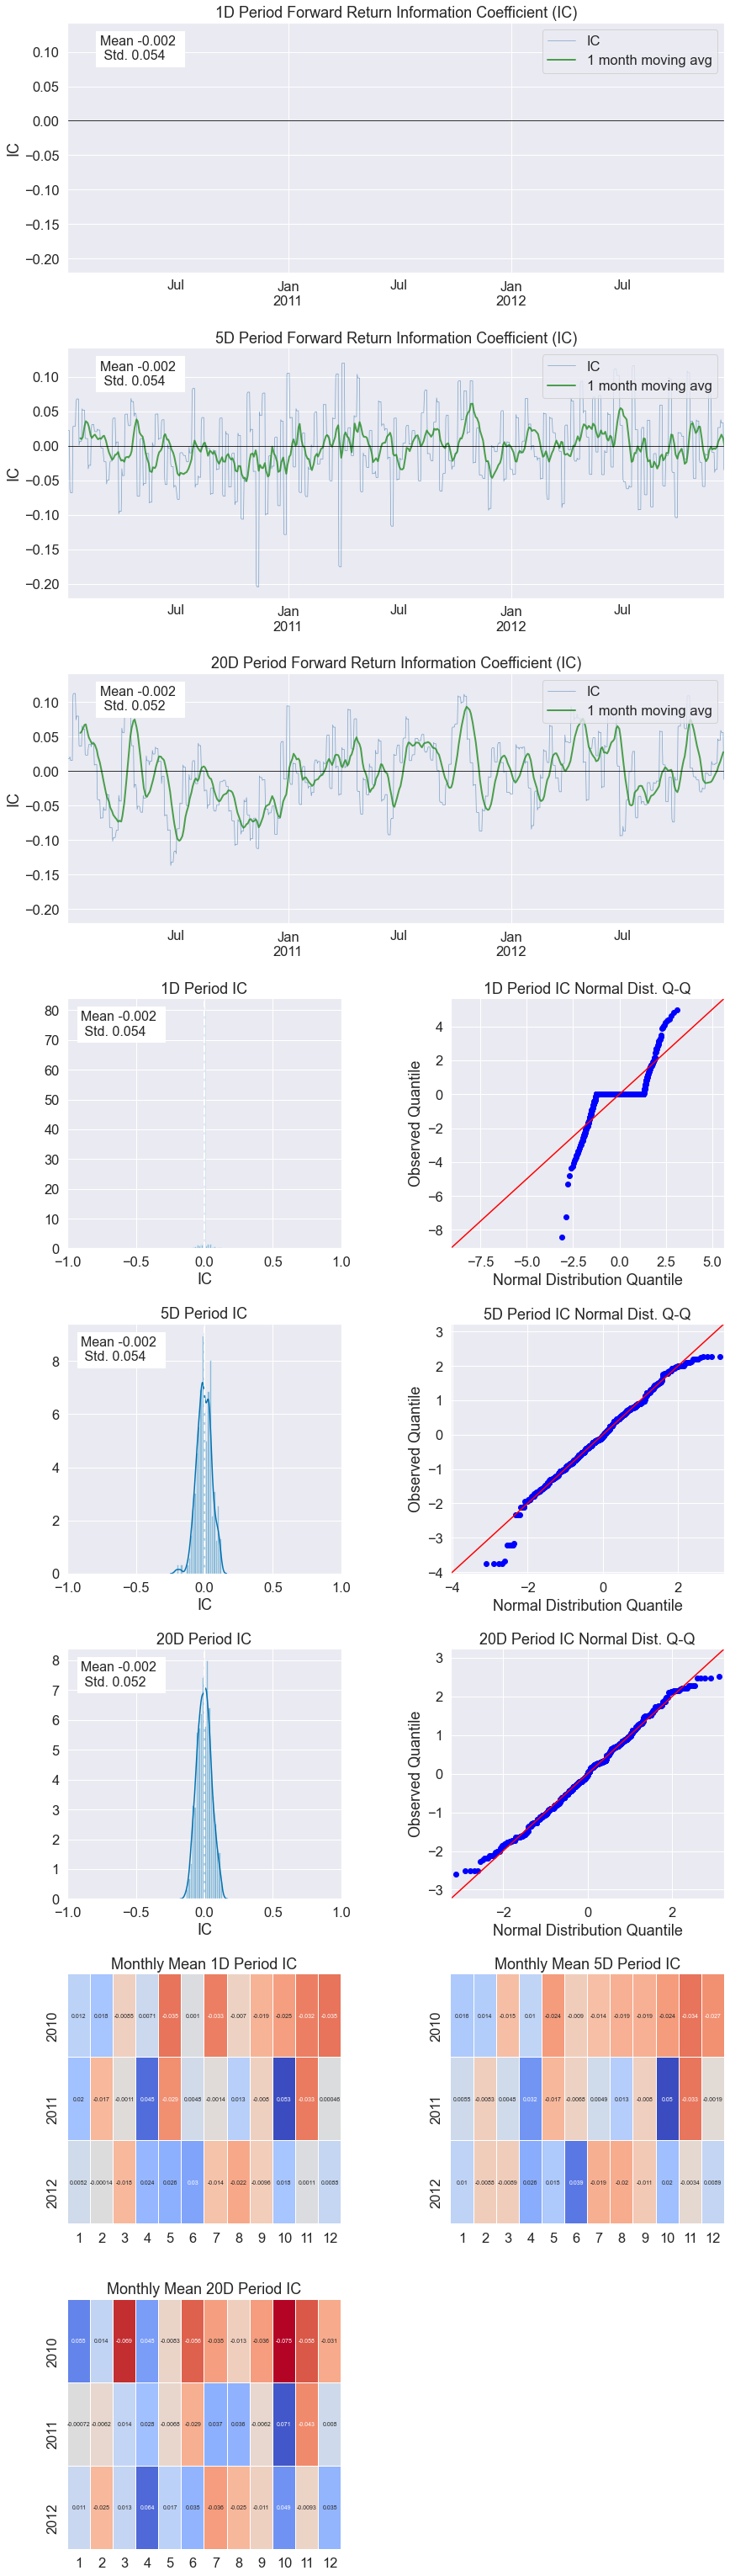

Returns Analysis


,1D,5D,20D
Ann. alpha,-0.004,-0.003,-0.002
beta,0.995,0.996,0.993
Ann. alpha (000300 based),-0.004,-0.003,-0.002
beta (000300 based),0.995,0.996,0.993
Mean Period Wise RateReturn Top Quantile (bps),3.284,3.364,2.789
Mean Period Wise RateReturn Bottom Quantile (bps),5.600,5.638,4.937
Mean Period Wise Spread (bps),-2.316,-2.286,-2.126


All Time Technique Index


,annual_return,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
1,0.126335,-0.409938,0.669797,0.991745,0.308180
2,0.076998,-0.405010,0.457621,0.663667,0.190114
3,0.098457,-0.433013,0.568353,0.815452,0.227377
4,0.088736,-0.400111,0.522533,0.758461,0.221779
5,0.062349,-0.413627,0.392771,0.551271,0.150737
Factor_Weighted Return,0.086792,-0.407075,0.513327,0.731463,0.213208
Top_minus_Bottom Return,-0.059009,-0.255049,-0.836916,-1.063918,-0.231365
Top_minus_Index Return,-0.026005,-0.162536,-0.541196,-0.716113,-0.159993


Year Wise Technique Index


annual_return  calmar_ratio  max_drawdown  sharpe_ratio  \
date                                                                    
2010-12-31 1       0.094496      0.230513     -0.409938      0.453258   
           2       0.087658      0.216435     -0.405010      0.428829   
           3       0.066898      0.154495     -0.433013      0.376470   
           4       0.024768      0.061903     -0.400111      0.224788   
           5      -0.068223     -0.164939     -0.413627     -0.089361   
2011-12-31 1       0.311019      2.912484     -0.106788      1.852985   
           2       0.228110      2.494646     -0.091440      1.614642   
           3       0.278136      2.731132     -0.101839      1.624689   
           4       0.249315      2.871741     -0.086817      1.606210   
           5       0.324836      3.395195     -0.095675      1.961174   
2012-12-31 1      -0.009752     -0.052480     -0.185814      0.014697   
           2      -0.070313     -0.298066     -0.235897     -0.374388   
           3      -0.033443     -0.168338     -0.198666     -0.135640   
           4       0.004006      0.021040     -0.190385      0.108374   
           5      -0.033932     -0.180013     -0.188495     -0.157747   

              sortino_ratio  
date                         
2010-12-31 1       0.693369  
           2       0.647990  
           3       0.546480  
           4       0.330634  
           5      -0.126891  
2011-12-31 1       2.743541  
           2       2.305282  
           3       2.427416  
           4       2.365309  
           5       2.941600  
2012-12-31 1       0.019634  
           2      -0.484414  
           3      -0.181762  
           4       0.150920  
           5      -0.199774

annual_return  calmar_ratio  max_drawdown  \
date                                                                            
2010-12-31 Factor_Weighted Return        0.010246      0.025169     -0.407075   
           Top_minus_Bottom Return      -0.150474     -0.672869     -0.223630   
           Top_minus_Index Return       -0.101979     -0.678491     -0.150303   
2011-12-31 Factor_Weighted Return        0.300586      3.112242     -0.096582   
           Top_minus_Bottom Return       0.008151      0.137318     -0.059358   
           Top_minus_Index Return        0.036187      1.290879     -0.028033   
2012-12-31 Factor_Weighted Return       -0.028312     -0.143130     -0.197802   
           Top_minus_Bottom Return      -0.026880     -0.473899     -0.056722   
           Top_minus_Index Return       -0.007107     -0.254431     -0.027933   

                                    sharpe_ratio  sortino_ratio  
date                                                             
2010-12-31 Factor_Weighted Return       0.174137       0.253326  
           Top_minus_Bottom Return     -1.822837      -2.150708  
           Top_minus_Index Return      -1.701432      -2.118846  
2011-12-31 Factor_Weighted Return       1.866631       2.746631  
           Top_minus_Bottom Return      0.163984       0.233809  
           Top_minus_Index Return       0.930086       1.405596  
2012-12-31 Factor_Weighted Return      -0.104335      -0.136566  
           Top_minus_Bottom Return     -0.452962      -0.619854  
           Top_minus_Index Return      -0.198369      -0.276720

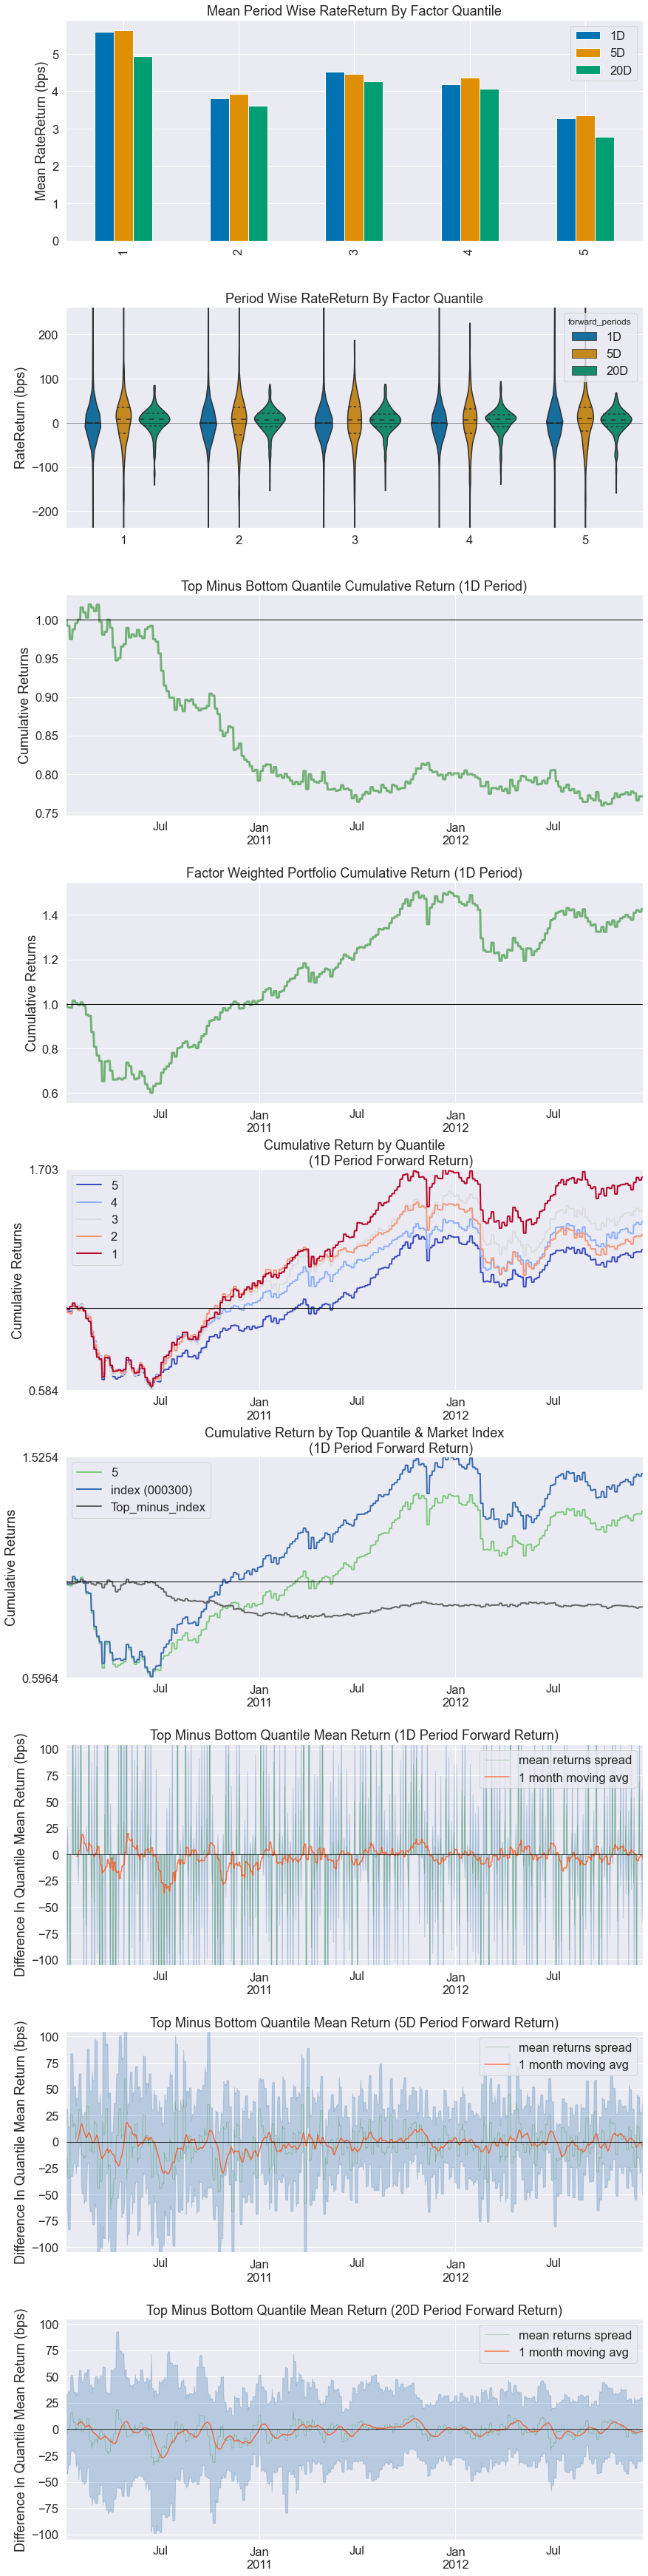

Turnover Analysis


,1D,5D,20D
Quantile 1 Mean Turnover,0.005,0.027,0.049
Quantile 2 Mean Turnover,0.015,0.072,0.134
Quantile 3 Mean Turnover,0.018,0.090,0.164
Quantile 4 Mean Turnover,0.014,0.070,0.128
Quantile 5 Mean Turnover,0.005,0.026,0.047


,1D,5D,20D
Mean Factor Rank Autocorrelation,1.0,0.998,0.994


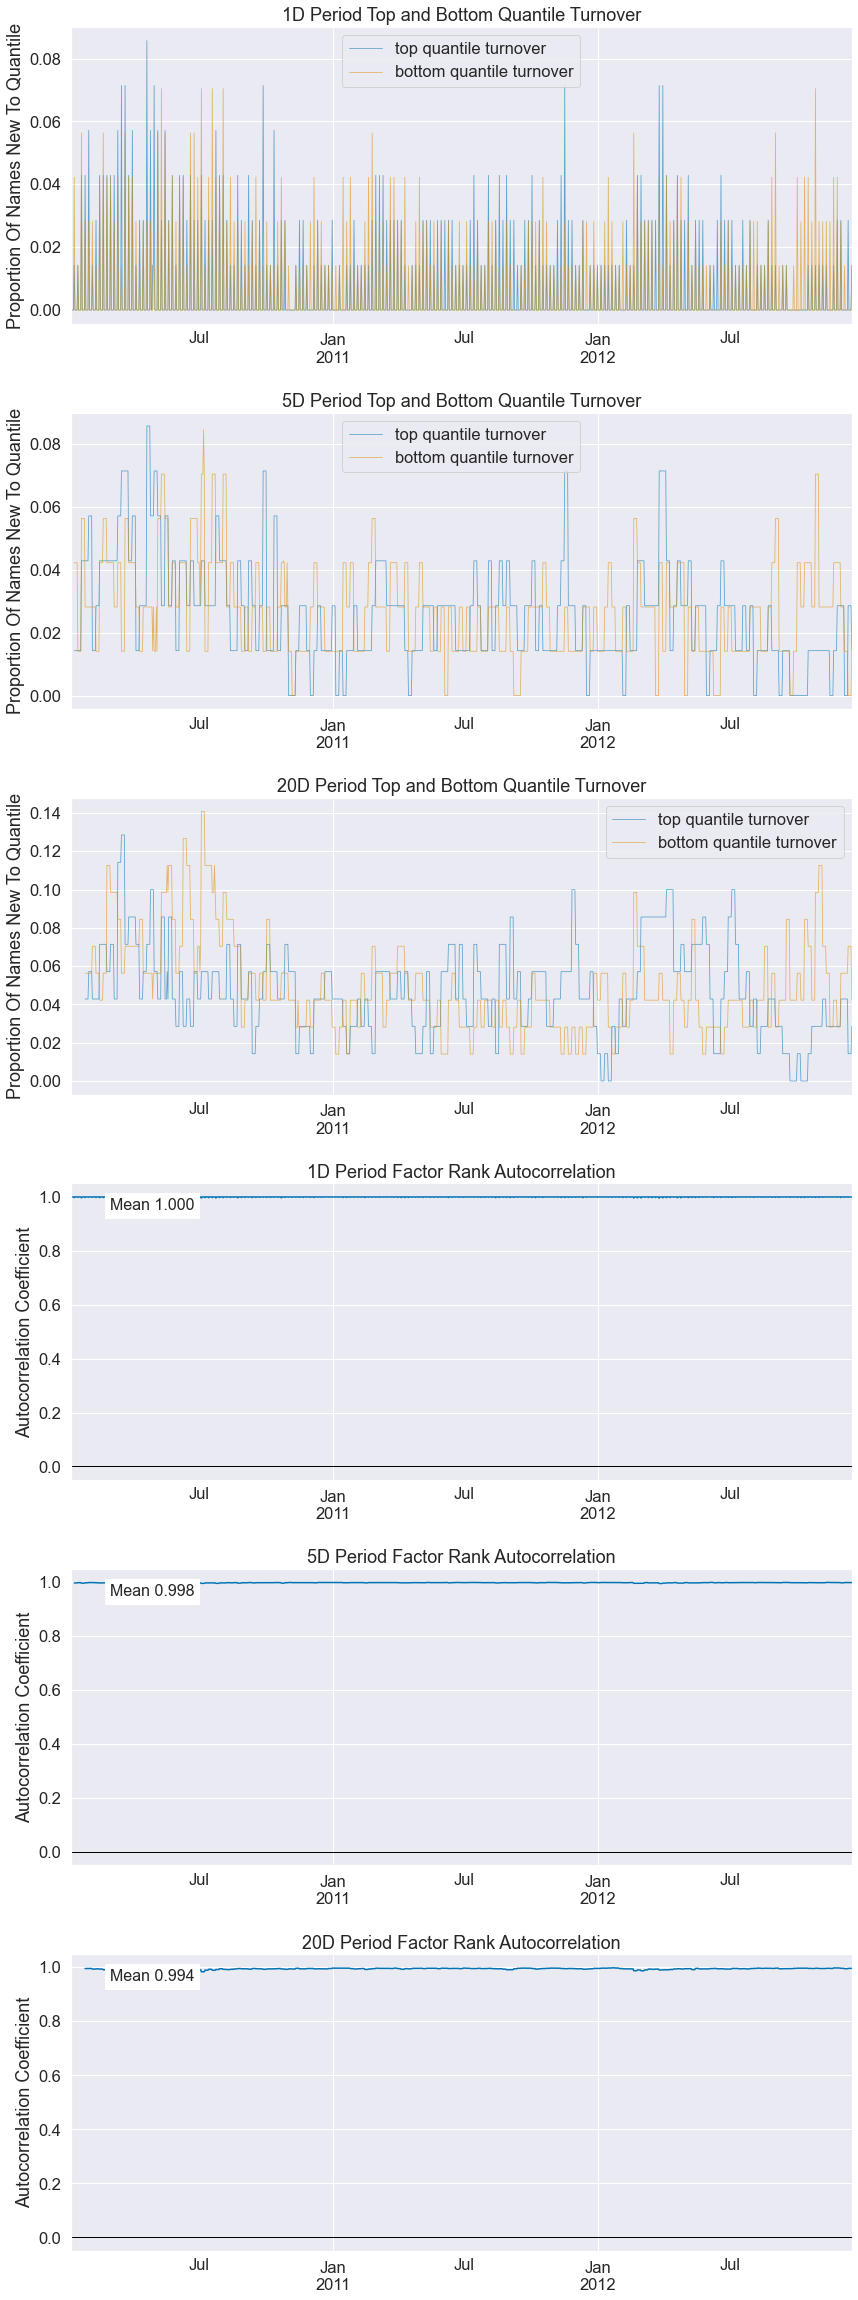

vol
Dropped 100.0% entries from factor data: 2.2% in forward returns computation and 97.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).


MaxLossExceededError: max_loss (35.0%) exceeded 100.0%, consider increasing it.

In [77]:
pricing_path=r'./factors/Pricing.csv'
for i in ['mom', 'vol', 'max52', 'min52']:
    print(i)
    factor_path=r'./factors/{}.csv'.format(i)
    alphalens_run(factor_path,pricing_path)